# Segmentation of Artificial 4D Image Data

This notebooks performs the experiment from section 3.1 in our paper.

## Load modules

In [1]:
import h5py
import igl
import matplotlib.pyplot as plt
import numpy as np
import polyscope as ps
import scipy
from scipy.sparse import csr_matrix
from scipy.interpolate import RegularGridInterpolator
from skimage.measure import marching_cubes
import torch
from tqdm import trange, tqdm

ps.init()

In [3]:
from mesh4d import (
    insert_tet_mesh_points,
    make_4d_disk,
    tet_edges,
    tet_edge_lengths,
    tet_normals,
    tet_volumes,
    scale_dep_laplacian,
    sparse_eye,
    vert_normals,
    orient_tets_away_from,
)

from vis4d import Vis4dGui

## Load Data

In [4]:
vol = h5py.File('data/sim_data_4d.mat')

vol = torch.from_numpy(np.array(vol.get('V')))
vol = (vol >= -0.01).float()

# Segment object in last 3D volume

Since we use simulated data, we just extract a level set from the ground truth label volume

In [5]:
tri_verts, tri_faces, _, _ = marching_cubes(vol[-1].numpy())
tri_verts /= vol.shape[1:]
tri_verts = tri_verts * 2 - 1
_, tri_verts, tri_faces, _, _ = igl.decimate(tri_verts, tri_faces, len(tri_faces) // 10)

tri_verts = torch.from_numpy(tri_verts.copy())
tri_faces = torch.from_numpy(tri_faces.copy())

tri_verts_mean = tri_verts.mean(dim=0, keepdim=True)
tri_verts = (tri_verts - tri_verts_mean) * 0.95 + tri_verts_mean

freeze = np.arange(len(tri_verts))

verts, tets = make_4d_disk(tri_verts, tri_faces, t=1 - 1/vol.shape[0])

verts = verts.double()

vol_thr = tet_volumes(verts, tets).mean()

In [6]:
tri_verts, tri_faces, _, _ = marching_cubes(vol[0].numpy())
tri_verts /= vol.shape[1:]
tri_verts = tri_verts * 2 - 1
_, tri_verts, tri_faces, _, _ = igl.decimate(tri_verts, tri_faces, len(tri_faces) // 5)

In [7]:
ps.register_surface_mesh('Mesh', tri_verts, tri_faces, smooth_shade=True)
ps.show()

# Define Mesh Refinement Functions

During the deformation we split based on volume as described in section 2.4.

We also use edge splitting to refine the tetrahedralization from TetGen which we use to fill in the triangle mesh extracted above.

In [8]:
def refine_tet_mesh(verts, chart_verts, tets, vol_thr=None, max_iter=10):
    """Refine mesh based on tet volume"""
    verts = verts.clone()
    chart_verts = chart_verts.clone()
    tets = tets.clone()

    volumes = tet_volumes(verts, tets)
    if vol_thr is None:
        vol_thr = volumes.mean()

    for i in range(max_iter):
        subdiv_idxs = volumes > vol_thr
        if not subdiv_idxs.any():
            break

        new_verts = verts[tets[subdiv_idxs]].mean(dim=1)
        new_chart_verts = chart_verts[tets[subdiv_idxs]].mean(dim=1)
        _, tets = insert_tet_mesh_points(chart_verts[:,:3].contiguous(), tets.to(torch.int32), new_chart_verts[:,:3].contiguous())
        verts = torch.cat([verts, new_verts], dim=0)
        chart_verts = torch.cat([chart_verts, new_chart_verts], dim=0)

        volumes = tet_volumes(verts, tets)

    return verts, chart_verts, tets

In [9]:
def split_long_edges(verts, chart_verts, tets, l, max_iter=10, freeze=None):
    """Refine mesh based on edge lengths"""
    assert verts.dtype == torch.double
    assert chart_verts.dtype == torch.double

    edges = tet_edges(tets)
    v0, v1 = torch.unbind(verts[edges], dim=1)
    edge_lengths = torch.sum((v1 - v0) ** 2, dim=1).sqrt()
    v0, v1 = torch.unbind(chart_verts[edges], dim=1)
    chart_edge_lengths = torch.sum((v1 - v0) ** 2, dim=1).sqrt()

    if l is None:
        l = edge_lengths.mean()

    for i in range(max_iter):
        split_idx = (edge_lengths > 4/3 * l)
        if not split_idx.any():
            break

        split_edges = edges[split_idx]
        if freeze is not None:
            frozen = freeze[split_edges].any(dim=1)
            split_edges = split_edges[~frozen]

        new_verts = verts[split_edges].mean(dim=1)
        new_chart_verts = chart_verts[split_edges].mean(dim=1)

        _, tets = insert_tet_mesh_points(chart_verts[:,:3].contiguous(), tets.to(torch.int32), new_chart_verts[:,:3].contiguous())
        verts = torch.cat([verts, new_verts], dim=0)
        chart_verts = torch.cat([chart_verts, new_chart_verts], dim=0)

        edges = tet_edges(tets)
        v0, v1 = torch.unbind(verts[edges], dim=1)
        edge_lengths = torch.sum((v1 - v0) ** 2, dim=1).sqrt()
        v0, v1 = torch.unbind(chart_verts[edges], dim=1)
        chart_edge_lengths = torch.sum((v1 - v0) ** 2, dim=1).sqrt()

    return verts, chart_verts, tets

In [10]:
# Perform initial refinement of TetGen output
l = 1 * tet_edge_lengths(verts, tets).mean()

start_verts, _, start_tets = split_long_edges(verts, 100*verts, tets, max_iter=1, l=l)
start_tets = orient_tets_away_from(start_verts, start_tets, torch.tensor([0, 0, 0, 1000]))

C:\Users\patmjen\OneDrive - Danmarks Tekniske Universitet\projects\4dseg\pycode\mesh4d.py:269: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BinaryOps.cpp:600.)
  edges = tet_edges(tets)


## Prepare Fitting Data and Interpolator

In [11]:
noise_sigma = 25.0
domain_half_size = torch.tensor([2, 1, 1, 1])

vol_fit = vol[80:]

xx = np.linspace(-domain_half_size[0] - 0.4, domain_half_size[0], vol_fit.shape[0])
yy = np.linspace(-domain_half_size[1], domain_half_size[1], vol_fit.shape[1])
zz = np.linspace(-domain_half_size[2], domain_half_size[2], vol_fit.shape[2])
tt = np.linspace(-domain_half_size[3], domain_half_size[3], vol_fit.shape[3])

torch.manual_seed(305)
vol_fit = 100 * (vol_fit + 1) + torch.randn_like(vol_fit) * noise_sigma
interp_vol = RegularGridInterpolator(
    (xx, yy, zz, tt),
    vol_fit.numpy().astype(np.uint8),
    method='linear',
    bounds_error=False,
    fill_value=255
)

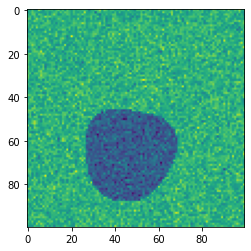

In [12]:
plt.imshow(vol_fit[-40, :, :, 45].squeeze())

## Derform Mesh to Fit Image Data

In [13]:
# Set parameters
c_in = 100 / 255  # From eq. (2)
c_out = 200 / 255  # From eq. (2)

smooth = 4e-3  # lambda from eq. (5)
step = 2e-1  # tau from eq. (5)
vf = 10  # s from section 2.4

# Initialize meshes
chart_verts = start_verts.clone()
verts = start_verts.clone()
tets = start_tets.clone()

verts = verts.double()
chart_verts = chart_verts.double()

# Initialize sparse smoothing matrix
edges = tet_edges(tets)
S = -smooth * scale_dep_laplacian(verts, edges, dtype=torch.double)
S = sparse_eye(len(verts)) - S
S = S.coalesce()
S = csr_matrix((S.values(), (S.indices()[0], S.indices()[1])), S.shape)

# Scale vertices to domain
verts *= domain_half_size[[1, 2, 3, 0]]

# Some vertices have their time coordinate frozen, cf. section 2.3
freeze_mask = torch.full((len(verts),), False)
freeze_mask[freeze] = True

all_verts_pre = []
all_tets_pre = []
all_verts_post = []
all_tets_post = []

# Start fitting
num_iters = 370
pbar = trange(num_iters, ncols=200)
for it in pbar:
    all_verts_pre.append(verts.numpy().copy())
    all_tets_pre.append(tets.numpy().copy())

    t_min = verts[:, 3].min()
    descr = f'min t: {t_min:.3f}, verts: {len(verts)}, tets: {len(tets)}'
    pbar.set_description(descr)

    # Update parameters for last 10 iterations, cf. section 3.1
    if it >= num_iters - 10:
        vf = 2.5
        smooth = 1e-3
        step = 5e-2

    # Perform external energy step
    vol_samples = torch.from_numpy(interp_vol(verts[:, [3, 0, 1, 2]].numpy())).squeeze() / 255.0
    f_ext = (c_in - c_out) * (2 * vol_samples - c_in - c_out)
    step_f_ext = step * f_ext[:, None] * vert_normals(verts, tets, weight='angle')
    step_f_ext[freeze, 3] = 0
    verts += step_f_ext

    # Perform internal energy step
    new_verts = np.zeros_like(verts.numpy())
    for i in range(verts.shape[1]):
        new_verts[:, i] = scipy.sparse.linalg.cg(S, verts[:, i], tol=1e-12, maxiter=200, x0=verts[:, i])[0]
    new_verts[freeze, 3] = verts[freeze, 3]
    verts = torch.from_numpy(new_verts)

    all_verts_post.append(verts.numpy().copy())
    all_tets_post.append(tets.numpy().copy())

    # If needed, subdivide the mesh and update the smoothing matrix
    if it % 10 == 0:
        verts, chart_verts, tets = refine_tet_mesh(verts, chart_verts, tets, vol_thr=vf * vol_thr, max_iter=1)
        chart_verts -= chart_verts.mean(dim=0)

        freeze_mask = torch.full((len(verts),), False)
        freeze_mask[freeze] = True

        tets = orient_tets_away_from(chart_verts, tets, torch.tensor([0, 0, 0, 1000]))

        edges = tet_edges(tets)
        S = -smooth * scale_dep_laplacian(verts, edges, dtype=torch.double)
        S = sparse_eye(len(verts)) - S
        S = S.coalesce()
        S = csr_matrix((S.values(), (S.indices()[0], S.indices()[1])), S.shape)

min t: -2.406, verts: 32017, tets: 207308: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 370/370 [02:27<00:00,  2.51it/s]


## Visualize Output

Launch a GUI built on [Polyscope](https://polyscope.run/py/) to visualize the data. It visualizes 3D cross sections of the fitted 4D mesh by intersecting the mesh with a hyperplane as described in section 2.6.

In the top right is a slider which can be used to change the time coordinate of the hyperplane. To change the orientation of the hyperplane, use the dropdown menu.

In [16]:
gui = Vis4dGui()
m = gui.register_hypersurface_mesh('Mesh', verts.float(), tets, smooth_shade=False)
gui.show()